# MNIST Handwritten Digit Classification with Custom Neural Network

The content for this notebook has been added. 

In future versions I will add explanations to each section. :)

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# import required modules
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from scikitplot.metrics import plot_roc

from NeuralNetwork import NeuralNetwork
from NetworkConfigHandler import NetworkConfigHandler
from PreProcessor import PreProcessor
from DataHandler import DataHandler
from ActivationFunctions import ActivationFunctions

In [2]:
mnist_train = '../data/mnist_data/mnist_train.csv'
mnist_test = '../data/mnist_data/mnist_test.csv'

In [3]:
# get datasets
delimiter = ','
features = [f'pixel_{i}' for i in range(784)]
targets = ['id']
column_names = targets + features

In [4]:
train_df = PreProcessor.load_data(mnist_train, column_names=column_names)
test_df = PreProcessor.load_data(mnist_test, column_names=column_names)

Reading data from ../data/mnist_data/mnist_train.csv
Reading data from ../data/mnist_data/mnist_test.csv


In [5]:
train_df

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create train-validation split

In [7]:
# use 40% of the training set for testing the framework 
# remove the line below to use the full training set 
train_df = train_df.sample(frac=.4)

train_df, val_df = PreProcessor.split_dataset(train_df, 0.2, seed=42)
train_df.shape, val_df.shape

((19200, 785), (4800, 785))

In [8]:
X_train = PreProcessor.normalize_dataset(train_df.loc[:, features].to_numpy())
y_train = train_df.loc[:, targets].to_numpy()

X_val = PreProcessor.normalize_dataset(val_df.loc[:, features].to_numpy())
y_val = val_df.loc[:, targets].to_numpy()

X_test = PreProcessor.normalize_dataset(test_df.loc[:, features].to_numpy())
y_test = test_df.loc[:, targets].to_numpy()

### Encode targets

In [9]:
encoder = OneHotEncoder(sparse=False)
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))

y_val_one_hot = encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

In [10]:
y_train[0], y_train_one_hot[0], y_train_one_hot.shape

(array([4]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), (19200, 10))

### View Sample Image

In [11]:
def plot_digit(digit, label=None):
    plt.imshow(digit.reshape(28, 28), cmap='gray')
    if label != None:
        plt.title(f'Digit: {label}')
    plt.show()

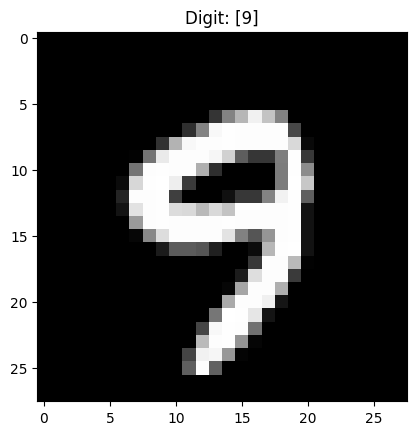

In [12]:
idx = random.randint(0, len(X_train))
plot_digit(X_train[idx], y_train[idx])

# 2. Create Input Data Pipeline with DataHandler

In [13]:
train_ds = DataHandler(X_train, y_train_one_hot)
val_ds = DataHandler(X_val, y_val_one_hot)
test_ds = DataHandler(X_test, y_test_one_hot)

In [14]:
print(train_ds.X.shape, train_ds.y.shape)
print(val_ds.X.shape, val_ds.y.shape)
print(test_ds.X.shape, test_ds.y.shape)

(19200, 784) (19200, 10)
(4800, 784) (4800, 10)
(10000, 784) (10000, 10)


# 3. Build Neural Network

In [15]:
# initialise neural network parameters
n = len(features)
alpha = 20
model_config = [
    {'units': n, 'activation': 'input'},
    {'units': 512, 'activation': 'leaky_relu'},
    {'units': 256, 'activation': 'leaky_relu'},
    {'units': 10, 'activation': 'sigmoid'}
]

In [16]:
# construct neural network
model = NeuralNetwork(model_config, alpha)

### Train Model

In [17]:
#train neural network
epochs = 5
model.fit(train_ds, val_ds, epochs)
# NN.evaluate(X_test, y_test)

Data received -> Training initiated...
Epoch 1/5


100%|██████████| 19200/19200 [02:08<00:00, 149.20it/s]


cost: 9.250775			accuracy: 0.73099
val_cost: 9.948904		val_accuracy: 0.753333
-------------------------------------------------
Epoch 2/5


100%|██████████| 19200/19200 [01:51<00:00, 171.89it/s]


cost: 9.188407			accuracy: 0.786042
val_cost: 9.320407		val_accuracy: 0.787292
-------------------------------------------------
Epoch 3/5


100%|██████████| 19200/19200 [01:48<00:00, 177.40it/s]


cost: 9.178856			accuracy: 0.793177
val_cost: 9.27903		val_accuracy: 0.771667
-------------------------------------------------
Epoch 4/5


100%|██████████| 19200/19200 [01:48<00:00, 176.60it/s]


cost: 9.175155			accuracy: 0.799531
val_cost: 9.210075		val_accuracy: 0.802083
-------------------------------------------------
Epoch 5/5


100%|██████████| 19200/19200 [01:56<00:00, 165.52it/s]


cost: 9.168419			accuracy: 0.804531
val_cost: 9.375438		val_accuracy: 0.8
-------------------------------------------------


# 4. Inspect Model Performance

In [18]:
model.evaluate(test_ds)

(9.419325413253544, 0.8102)

In [19]:
test_probabilities = model.predict(test_ds)
test_probabilities.shape

(10000, 10, 1)

In [20]:
test_predictions = np.argmax(test_probabilities, axis=1)
test_predictions.shape

(10000, 1)

In [21]:
model.cost_hist

{'Train_cost': [9.250775063431442,
  9.188406872868306,
  9.178856296899255,
  9.17515474217005,
  9.168419499182239],
 'Validation_cost': [9.948903872832595,
  9.320406574459879,
  9.279029827698828,
  9.210075010355748,
  9.375438462630305]}

### Plot Model Training History

In [22]:
model_history = {
    'accuracy':         model.accuracies['Train_set'],
    'val_accuracy':     model.accuracies['Validation_set'],
    'cost':             model.cost_hist['Train_cost'],
    'val_cost':     model.cost_hist['Validation_cost']
}
model_history

{'accuracy': [0.730989583333176,
  0.7860416666664592,
  0.7931770833331194,
  0.7995312499997803,
  0.8045312499997758],
 'val_accuracy': [0.7533333333333333,
  0.7872916666666666,
  0.7716666666666666,
  0.8020833333333334,
  0.8],
 'cost': [9.250775063431442,
  9.188406872868306,
  9.178856296899255,
  9.17515474217005,
  9.168419499182239],
 'val_cost': [9.948903872832595,
  9.320406574459879,
  9.279029827698828,
  9.210075010355748,
  9.375438462630305]}

In [23]:
def plot_training_curves(history):
    
    cost = np.array(history['cost'])
    val_cost = np.array(history['val_cost'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['val_accuracy'])

    epochs = range(len(history['cost']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, cost, label='training_loss', marker='o')
    ax1.plot(epochs, val_cost, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, cost, val_cost, where=(cost > val_cost), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, cost, val_cost, where=(cost < val_cost), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Cost (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();


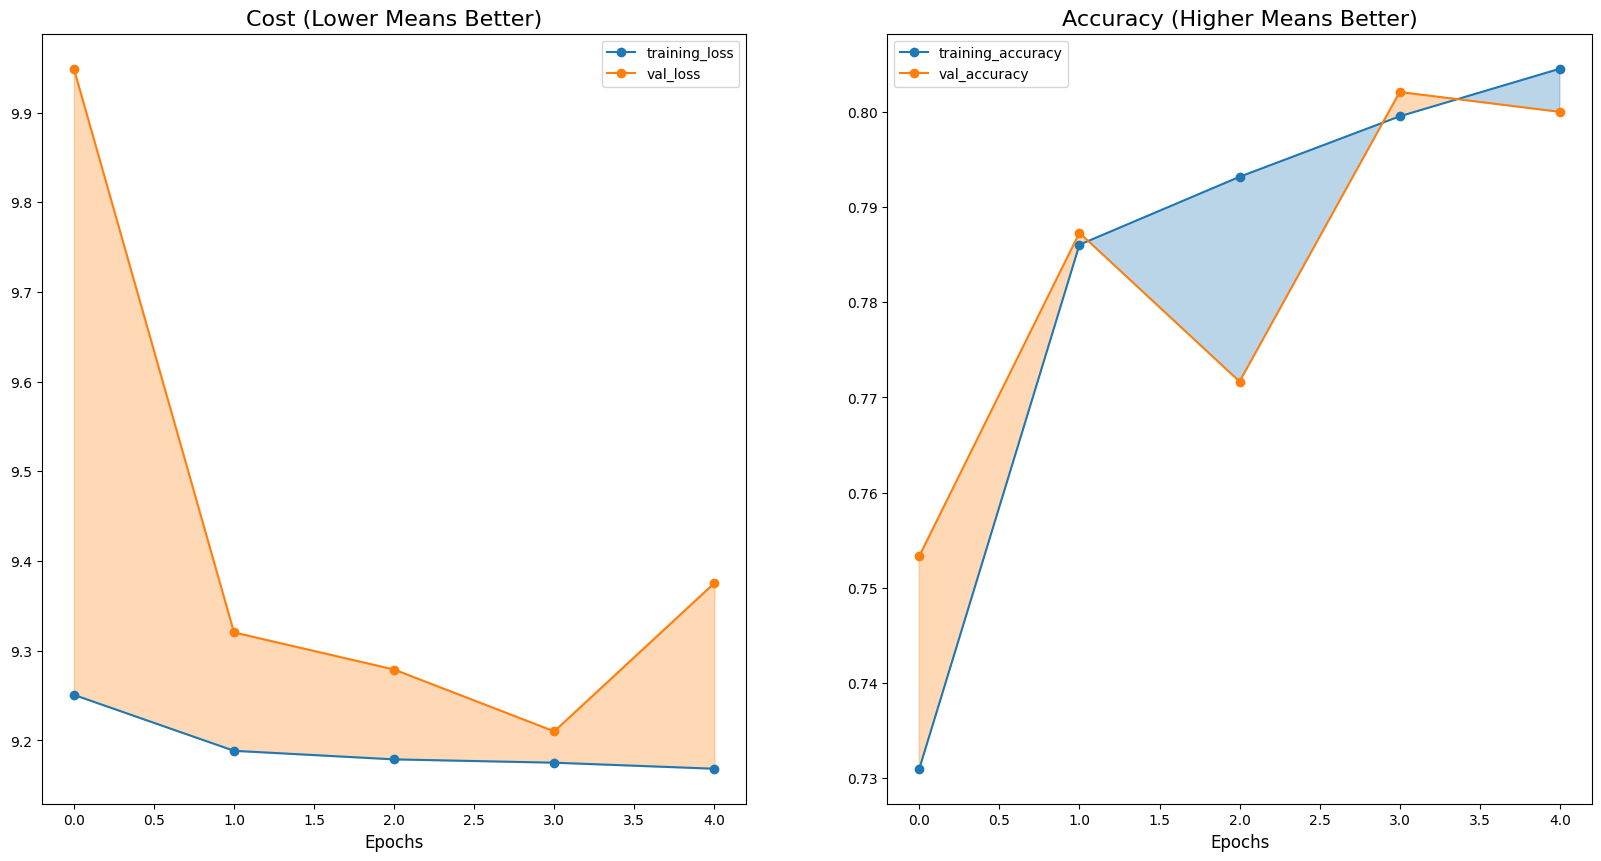

In [24]:
plot_training_curves(model_history)

### Plot Model ROC Curves

In [25]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=12, norm=False, savefig=False): 

    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Greens) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes), 
        xticklabels=labels, # axes will labeled with class names (if they exist) or ints
        yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(
                j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(
                j, i, f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

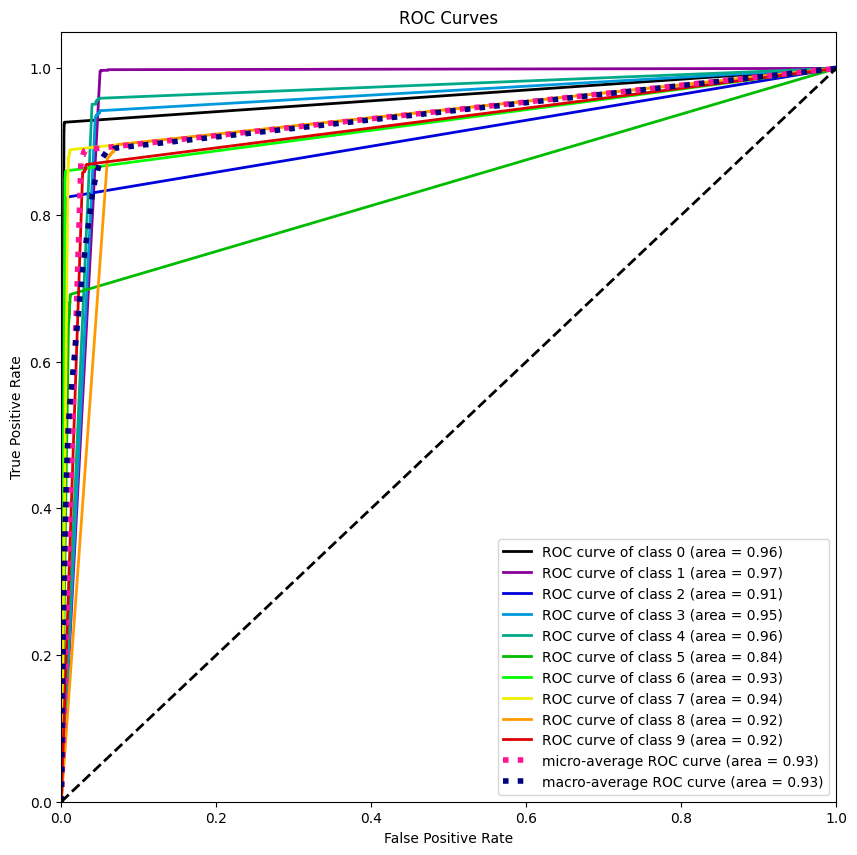

In [26]:
plot_roc(
    y_test, 
    test_probabilities, 
    figsize=(10, 10), 
    title_fontsize='large');

### Inspect Confusion Matrix

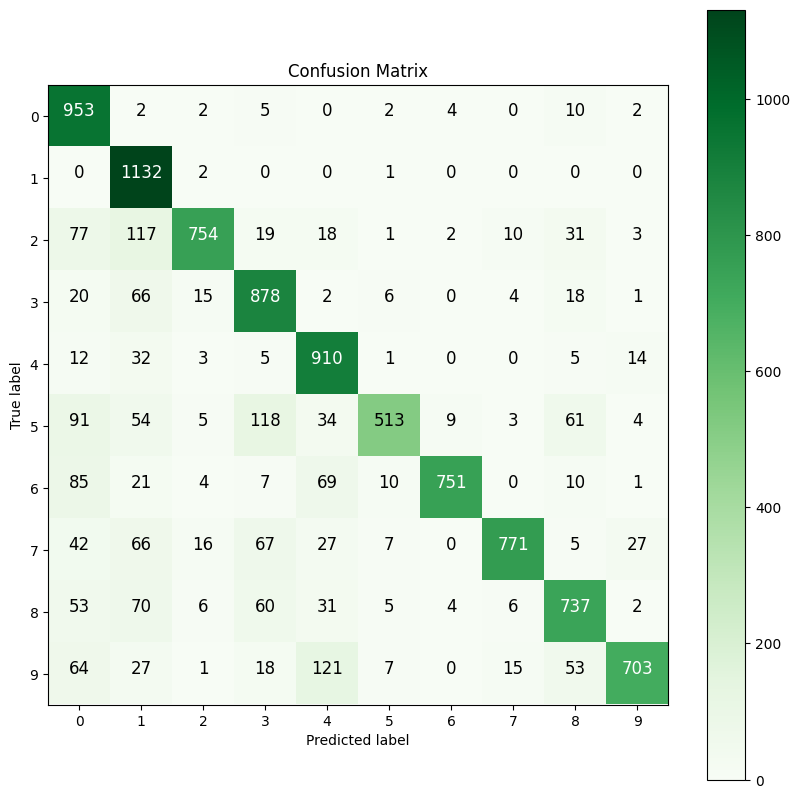

In [27]:
generate_confusion_matrix(y_test, test_predictions)

### View Classification Report

In [28]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.68      0.97      0.80       980
           1       0.71      1.00      0.83      1135
           2       0.93      0.73      0.82      1032
           3       0.75      0.87      0.80      1010
           4       0.75      0.93      0.83       982
           5       0.93      0.58      0.71       892
           6       0.98      0.78      0.87       958
           7       0.95      0.75      0.84      1028
           8       0.79      0.76      0.77       974
           9       0.93      0.70      0.80      1009

    accuracy                           0.81     10000
   macro avg       0.84      0.81      0.81     10000
weighted avg       0.84      0.81      0.81     10000



### Inspect Model Metrics

In [29]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    # top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=3), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, 
                                                                                 y_pred, 
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    # print('_____________________________________________')
    # print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    return


In [30]:
generate_preformance_scores(y_test, test_predictions, test_probabilities)


Performance Metrics:

accuracy_score:		0.8102

_____________________________________________
precision_score:	0.83823

_____________________________________________
recall_score:		0.8102

_____________________________________________
f1_score:		0.80875

_____________________________________________
matthews_corrcoef:	0.79226



### View Test Sample Predictions

In [31]:
def display_digits(neural_network, X_data, y_data, img_count):
    fig = plt.figure(figsize=(14, 14))

    for i in range(1, img_count + 1):
        idx = random.randint(0, len(X_data) - 1)
        img = np.reshape(X_data[idx], (np.shape(X_data[idx])[0], 1))
        id = y_data[idx]
        
        output = neural_network.forward_propagate(img)
        prediction = np.argmax(output, axis=0)

        prob = output[int(prediction)]
        pixels = img.reshape((28, 28))
        plt.subplot(4, 5, i)
        
        plt.imshow(pixels, cmap='gray')
        plt.title(f'True Label: {id}')
        plt.xlabel(f'NN prediction: {prediction}\nProbability: {round(prob[0], 3)}') 

    plt.subplots_adjust(wspace=0.9, hspace=0.9)
    plt.show()

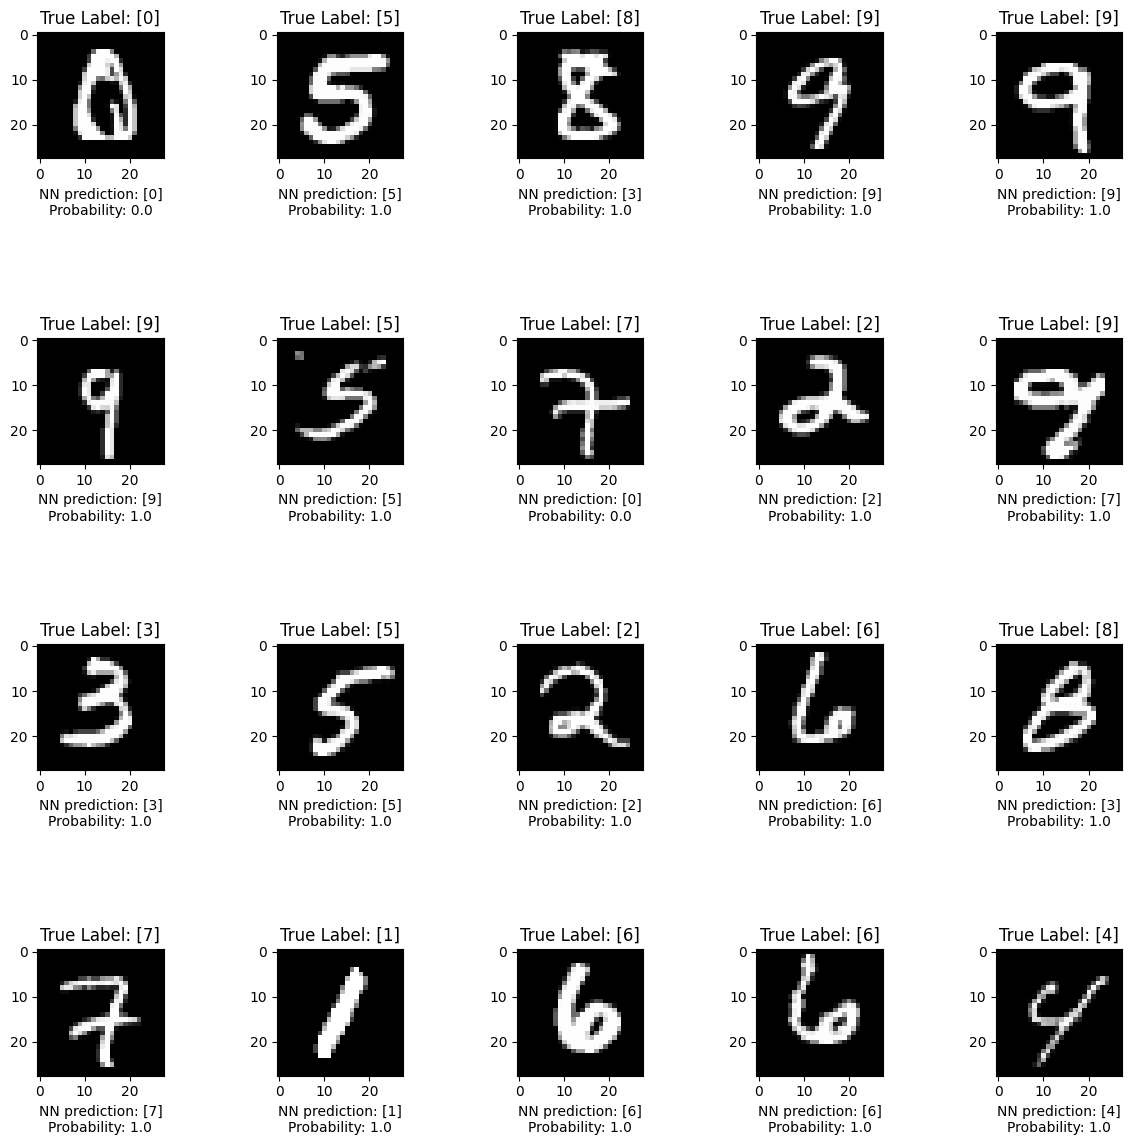

In [32]:
display_digits(model, X_test, y_test, 20)

# 5. Save Model (Optional)

In [33]:
NetworkConfigHandler.store_network_config(model, 'test')

Preparing Neural Network data for storage...
Saving data...
Neural Network data stored successfully!


In [34]:
test_model = NetworkConfigHandler.load_network_config('test')

Loading Neural Network data...
Re-constructing Neural Network with loaded data...
Neural Network re-constructed and ready for usage!


In [35]:
random_idx = random.randint(0, len(test_ds) - 1)
x_t, y_t = test_ds[random_idx]

In [36]:
pred_y_t = test_model(x_t)

In [37]:
print(f'y_t:\t\t{np.argmax(y_t)}')
print(f'prediction:\t{np.argmax(y_t)}')

y_t:		1
prediction:	1
